### Description

The code in this notebook is presented almost as-is. You can find the full solution [here](https://github.com/ilyanovo/isic-2024).

This solution achieves a score of 0.17264 on the private leaderboard and 0.18611 on the public leaderboard.

It is not the best solution. Replacing the Edgenext model with a model trained on synthetic data resulted in a score of 0.17332 on the private leaderboard.

In [58]:
# import h5py
# import os
# from PIL import Image
# from io import BytesIO

# # === Settings ===
# hdf5_file_path = '../data/original/test-image.hdf5'
# output_dir = '../data/original/test-image/image'

# # === Create output directory ===
# os.makedirs(output_dir, exist_ok=True)

# # === Load HDF5 file ===
# with h5py.File(hdf5_file_path, 'r') as hdf:
#     for dataset_name in hdf.keys():
#         dataset = hdf[dataset_name]
#         try:
#             data = dataset[()]  # Scalar data

#             if isinstance(data, bytes):
#                 # Decode image from bytes
#                 image = Image.open(BytesIO(data))
#                 output_path = os.path.join(output_dir, f'{dataset_name}.jpg')
#                 image.save(output_path)
#                 print(f"Saved {output_path}")
#             else:
#                 print(f"Skipping {dataset_name}: not raw bytes.")

#         except Exception as e:
#             print(f"Failed to process '{dataset_name}': {e}")


# Imports

In [59]:
import os, cv2
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

from sklearn.utils import resample

import optuna

from tqdm import tqdm


import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings("ignore")

# Feature Assign

In [60]:
root = Path('../')

train_path = root / 'data/original/train-metadata.csv'
test_path = root / 'data/original/test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]


new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]


cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient', "tbp_lv_areaMM2_patient", "tbp_lv_areaMM2_bp"] #'count_per_patient_bp'
# feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols
feature_cols = num_cols + cat_cols

In [61]:
len(feature_cols)

40

In [62]:
len(norm_cols)

76

In [63]:
# temp = pd.read_csv("../data/original/train-metadata.csv")
# temp['tbp_tile_type'].unique()

In [64]:
# feature_cols1 = feature_cols

# EVA Config

In [65]:
test_df = pd.read_csv(test_path)
test_h5 = root / 'data/original/test-image.hdf5'

# Set up device and random seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

# device = torch.device("cpu")

CONFIG = {
    "seed": 42,
    "epochs": 500,
    "img_size": 336, #336,
    "model_name": 'eva02_small_patch14_336.mim_in22k_ft_in1k',
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 2000,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "group_col": 'patient_id',
    "device": device
}

transformations_base = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758], 
            max_pixel_value=255.0,
            p=1.0
        ),
    ToTensorV2(),
    ], p=1.)

def set_seed(random_seed):
    random.seed(random_seed)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, drop_path_rate=0, drop_rate=0, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            heckpoint_path=checkpoint_path,
            drop_rate=drop_rate, 
            drop_path_rate=drop_path_rate)

        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid() if num_classes == 1 else nn.Softmax()

    def forward(self, images):
        return self.sigmoid(self.model(images))
    
    
    
class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.df = df
        self.file_hdf = file_hdf  # store path, not file handle
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        
        with h5py.File(self.file_hdf, mode="r") as fp_hdf:
            img = np.array(Image.open(BytesIO(fp_hdf[isic_id][()])))
        
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target,
        }


def prepare_loaders(df_train, h5_file, augmentations, CONFIG, num_workers=10):
    
    train_dataset = ISICDataset(df_train, h5_file, transforms=augmentations)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=num_workers, shuffle=False, pin_memory=True, drop_last=False)
    
    return train_loader


@torch.inference_mode()
def generate_predictions(model, dataloader, device):
    model.eval()
    

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    predictions_all = []
    targets_all = []
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        outputs = model(images).squeeze()

        predictions_all.append(outputs.cpu().numpy())
        targets_all.append(targets.cpu().numpy())
    
    gc.collect()

    targets_all = np.concatenate(targets_all)
    predictions_all = np.concatenate(predictions_all)
    
    return targets_all, predictions_all


model = ISICModel(CONFIG['model_name'], pretrained=False, num_classes=3)
model.load_state_dict( torch.load('../weights/skin-models-base/ema_small_pretrained', weights_only=True) )
model.to(CONFIG['device']);

test_df["path"] = '../data/original/test-image/image/' + test_df['isic_id'] + ".jpg"
test_df['target'] = 0
data_loader_test = prepare_loaders(test_df, test_h5, transformations_base, CONFIG, num_workers=0)

targets_all, predictions_all = generate_predictions(model, data_loader_test, device)

test_df['old_set_0'] = predictions_all[:, 0]
test_df['old_set_1'] = predictions_all[:, 1]
test_df['old_set_2'] = predictions_all[:, 2]

test_df[['isic_id', 'old_set_0', 'old_set_1', 'old_set_2']].to_parquet(
    'old_data_model_forecast__test.parquet')
model.to('cpu');

Using device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti
Number of GPUs: 1


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


# EVA Pred on Test

In [66]:
test_df = pd.read_csv(test_path)

test_df["path"] = '../data/original/test-image/image/' + test_df['isic_id'] + ".jpg"
test_df['target'] = 0
data_loader_test = prepare_loaders(test_df, test_h5, transformations_base, CONFIG, num_workers=0)
predctions_all = []

base_model_path = "../weights/eva"
for base_model_index in range(5):
    base_model_full_path = os.path.join(base_model_path, f"model__{base_model_index}")
    
    model = ISICModel(CONFIG['model_name'], pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(base_model_full_path, weights_only=True))
    model.to(CONFIG['device']);
    targets_all, predictions_all = generate_predictions(model, data_loader_test, device)
    test_df[f"predictions__{base_model_index}"] = predictions_all
    model.to('cpu');
    
test_df = test_df[
    ['isic_id', 'patient_id',
         'predictions__0', 'predictions__1', 'predictions__2', 'predictions__3', 'predictions__4']
].reset_index(drop=True)

100%|██████████| 1/1 [00:00<00:00, 23.37it/s]


In [67]:
def add_pation_norm(df, column_name: str, column_name_new: str):
    df = df.merge(
        df.groupby("patient_id").agg(**{
            column_name_new: pd.NamedAgg(column_name, 'mean')
        }).reset_index(), how="left", on=["patient_id"])

    df[column_name_new] = df[column_name] / df[column_name_new]
    return df

In [68]:
oof_forecasts_eva = pd.read_parquet('../data/artifacts/oof_forecasts_eva_base.parquet')
oof_forecasts_eva_agg = oof_forecasts_eva.groupby('fold_n').agg(**{
        "mean_preds": pd.NamedAgg("tmp_predictions_all", "mean"),
        "std_preds": pd.NamedAgg("tmp_predictions_all", "std")})

#Scaling works better on both public and private leaderboards when it is done using values from just one fold
for i in range(2):
    test_df[f'predictions__{i}'] = (
        test_df[f'predictions__{i}'] - oof_forecasts_eva_agg.loc[0].mean_preds
    ) / oof_forecasts_eva_agg.loc[0].std_preds
    
test_df["predictions_eva"] = test_df[[f'predictions__{i}' for i in range(2)]].mean(axis=1)
test_df_eva = test_df.copy()


# tmp_predictions_all_rank_pr
# print(oof_forecasts_eva.columns)
oof_forecasts_eva = oof_forecasts_eva[['isic_id', 'patient_id', 'tmp_predictions_all']].rename(columns={
    'tmp_predictions_all': 'predictions_eva'
})

test_df_eva = add_pation_norm(
    test_df_eva, column_name='predictions_eva', column_name_new='predictions_eva_m')
oof_forecasts_eva = add_pation_norm(
    oof_forecasts_eva, column_name='predictions_eva', column_name_new='predictions_eva_m')

In [69]:
# Why patient wise score normalization is useful? (predictions_eva_m)

# → In medical images (like ISIC skin cancer):

#     Same patient can have very bright/dark/unique images.

#     But ranking within the same patient helps model not get confused.

#     This reduces bias from weird patients who always get very high or low scores.

# Why do we need predictions_eva_m?

# → Intuition:

#     In ISIC dataset:

#         One patient may have multiple lesions/images.

#         If a model tends to over-score/under-score all images of a patient → it hurts LB performance.

# → Solution:

#     Normalize prediction within each patient.

#     Ensure relative ranking between images is preserved across patients.

# EdgeNeXt Config

In [70]:
class ISICModelEdgnet(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, *args, **kwargs):
        super(ISICModelEdgnet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, global_pool='avg')
        self.sigmoid = nn.Sigmoid()
    def forward(self, images):
        return self.sigmoid(self.model(images))

In [71]:
class ISICModelEdgnet(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, *args, **kwargs):
        super(ISICModelEdgnet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, global_pool='avg')
        self.sigmoid = nn.Sigmoid()
    def forward(self, images):
        return self.sigmoid(self.model(images))
    

CONFIG = {
    "seed": 42,
    "epochs": 500,
    "img_size": 256, #336,
#     "model_name": 'eva02_small_patch14_336.mim_in22k_ft_in1k',
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 2000,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "group_col": 'patient_id',
    "device": device
}

transformations_base = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(
            mean=[0.4815, 0.4578, 0.4082], 
            std=[0.2686, 0.2613, 0.2758], 
            max_pixel_value=255.0,
            p=1.0
        ),
    ToTensorV2(),
    ], p=1.)

# EdgeNeXt Preds on Test

In [72]:
test_df = pd.read_csv(test_path)

test_df["path"] = '../data/original/test-image/image/' + test_df['isic_id'] + ".jpg"
test_df['target'] = 0
data_loader_test = prepare_loaders(test_df, test_h5, transformations_base, CONFIG, num_workers=0)


base_model_path = "../weights/edgenet"
for base_model_index in range(5):
    base_model_full_path = os.path.join(base_model_path, f"model__{base_model_index}")
    
    model = ISICModelEdgnet('edgenext_base.in21k_ft_in1k', pretrained=False, num_classes=1)
    model.load_state_dict(torch.load(base_model_full_path, weights_only=True))
    model.to(CONFIG['device']);
    targets_all, predictions_all = generate_predictions(model, data_loader_test, device)
    test_df[f"predictions__{base_model_index}"] = predictions_all
    model.to('cpu');
    
oof_forecasts_edgenext = pd.read_parquet('../data/artifacts/oof_forecasts_edgenext_base.parquet')
oof_forecasts_edgenext_agg = oof_forecasts_edgenext.groupby('fold_n').agg(**{
        "mean_preds": pd.NamedAgg("tmp_predictions_all", "mean"),
        "std_preds": pd.NamedAgg("tmp_predictions_all", "std")})

#Scaling works better on both public and private leaderboards when it is done using values from just one fold
for i in range(5):
    test_df[f'predictions__{i}'] = (
        test_df[f'predictions__{i}'] - oof_forecasts_edgenext_agg.loc[0].mean_preds
    ) / oof_forecasts_edgenext_agg.loc[0].std_preds
    
test_df["predictions_edg"] = test_df[[f'predictions__{i}' for i in range(5)]].mean(axis=1)
test_df = test_df[['isic_id', 'patient_id', 'predictions_edg']].reset_index(drop=True)
test_df_edg = test_df.copy()


oof_forecasts_edgenext = oof_forecasts_edgenext[['isic_id', 'patient_id', 'tmp_predictions_all']].rename(columns={
    'tmp_predictions_all': 'predictions_edg'
})


test_df_edg = add_pation_norm(
    test_df_edg, column_name='predictions_edg', column_name_new='predictions_edg_m')
oof_forecasts_edgenext = add_pation_norm(
    oof_forecasts_edgenext, column_name='predictions_edg', column_name_new='predictions_edg_m')

100%|██████████| 1/1 [00:00<00:00, 33.53it/s]


# Data Read & Feature Engineering

In [73]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            tbp_lv_areaMM2_patient = pl.col('tbp_lv_areaMM2').sum().over('patient_id'),
        )
        .with_columns(
            tbp_lv_areaMM2_bp = pl.col('tbp_lv_areaMM2').sum().over(['patient_id', 'anatom_site_general']),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [74]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [75]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [76]:
# '../input/old-models-predictions/old_data_model_forecast.parquet'
def add_old_model_preds(df_train, path):
    old_data_model_preds = pd.read_parquet(path) #old_data_model_forecast
    feature_cols_new = []
    df_train = df_train.merge(old_data_model_preds, how="left", on=["isic_id"])
    feature_cols_new += [i for i in old_data_model_preds.columns if i!='isic_id']
    df_train = df_train.merge(
        df_train.groupby("patient_id").agg(**{
            "old_set_0_m": pd.NamedAgg('old_set_0', 'mean'),
            "old_set_1_m": pd.NamedAgg('old_set_1', 'mean'),
            "old_set_2_m": pd.NamedAgg('old_set_2', 'mean')
        }).reset_index(), how="left", on=["patient_id"])

    df_train['old_set_0_m'] = df_train['old_set_0'] / df_train['old_set_0_m']
    df_train['old_set_1_m'] = df_train['old_set_1'] / df_train['old_set_1_m']
    df_train['old_set_2_m'] = df_train['old_set_2'] / df_train['old_set_2_m']
    feature_cols_new += ['old_set_0_m', 'old_set_1_m', 'old_set_2_m']
    return df_train, feature_cols_new

In [77]:
df_train = read_data(train_path)
print(df_train.shape)
df_test = read_data(test_path)
print(df_test.shape)
df_subm = pd.read_csv(subm_path, index_col=id_col)
df_train, df_test = preprocess(df_train, df_test)
print(df_train.shape, df_test.shape)

(401059, 176)
(3, 165)
(401059, 223) (3, 212)


In [78]:
# len(cat_cols)

In [79]:
# cat_cols

In [80]:
# original features --> 55
# after feat engr --> 176
# after preprocessing --> 223

In [81]:
# set(df_train.columns) - set(feature_cols1)

## Data Cleaning

In [82]:
for col in feature_cols: 
    df_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    
cat_columns = list(df_test.select_dtypes('category').columns)
for col in feature_cols[76:77]:
    if col not in cat_columns:
        if df_test[col].isna().mean() != 1:
            filler = df_test[col].median()
        else:
            filler = 0
        df_test[col] = df_test[col].fillna(filler)
    else:
        vc = df_test[col].value_counts()
        if vc.shape[0] == 0:
            filler = 0
        else:
            filler = vc.index[0]
    
        df_test[col] = df_test[col].fillna(filler)

## Calculate LOF Feature

In [83]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

top_lof_features = [
        'tbp_lv_H','hue_contrast',
       'age_normalized_nevi_confidence_2', 'tbp_lv_deltaB',
       'color_uniformity', 'tbp_lv_z',
       'clin_size_long_diam_mm', 'tbp_lv_y',
       'position_distance_3d', 'hue_contrast',
       'tbp_lv_stdLExt', 'mean_hue_difference',
       'age_normalized_nevi_confidence',
       'lesion_visibility_score',
       'position_distance_3d',
       'tbp_lv_minorAxisMM', 'tbp_lv_Hext']

# top_lof_features were generated using permutation feature importance

In [84]:
def get_lof_score(df_train, top_lof_features):
    scalled_array = StandardScaler().fit_transform(df_train[top_lof_features])
    outiler_factors = []
    for patient_id in tqdm(df_train.patient_id.unique()):
        mask = (df_train['patient_id'] == patient_id).values
        sum_mask = sum(mask)
        if sum_mask < 3:
            continue
        patient_emb = scalled_array[mask]
        clf = LocalOutlierFactor(n_neighbors=min(30, sum_mask))
        clf.fit_predict(patient_emb)


        outiler_factors.append(pd.DataFrame(
            {"isic_id": df_train[mask].index.values,
            "of": clf.negative_outlier_factor_}))

    if len(outiler_factors) == 0:
        df_train['of'] = -1
        return df_train
    
    outiler_factors = pd.concat(outiler_factors).reset_index(drop=True)

    df_train = df_train.merge(outiler_factors.set_index('isic_id'), how="left", left_index=True, right_index=True)
    df_train['of'] = df_train['of'].fillna(-1)
    return df_train

df_train = get_lof_score(df_train, top_lof_features)
df_test = get_lof_score(df_test, top_lof_features)

feature_cols += ['of']

100%|██████████| 3/3 [00:00<?, ?it/s]


In [ ]:
# What is LOF (Local Outlier Factor)?

#     It’s a machine learning technique.

#     Used to detect outliers.

#     Output:

#         Negative value.

#         Smaller value = more likely outlier.

#         Larger value (closer to 0) = more normal.

# Why is this LOF(local outlier factor) Brilliant?

# → This is a patient-level relative feature.
# → Not absolute like size or color.
# → Helps model catch:

# "This lesion looks unusual for this patient"

# Value of of	Interpretation
# Very small (like -5)	Image looks very different from patient's other images (maybe cancer?)
# Around -1	Image looks similar to patient's other images (normal)

# → If patient has less than 3 images → skip (LOF needs minimum 3 points to compare).

## Merge old model and new model feats

In [85]:
df_train, extra_f = add_old_model_preds(df_train, '../data/artifacts/old_data_model_forecast.parquet')
df_test, extra_f = add_old_model_preds(df_test, 'old_data_model_forecast__test.parquet')

In [86]:
df_train = df_train.merge(oof_forecasts_eva, how="left", on='isic_id')
df_test = df_test.merge(test_df_eva, how="left", on='isic_id')

# feature_cols += extra_f
feature_cols += ['predictions_eva', 'predictions_eva_m']

In [87]:
df_train = df_train.merge(oof_forecasts_edgenext, how="left", on='isic_id')
df_test = df_test.merge(test_df_edg, how="left", on='isic_id')

feature_cols += ['predictions_edg', 'predictions_edg_m']

In [88]:
df_train.shape

(401059, 237)

# Optuna HyperParam Tuned Models

In [89]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    "device" : "gpu",
    'random_state':     seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}

cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      seed,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

xgb_params  = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
    "device": "cuda"
}

# Model Training with Cross Validation

In [90]:
def custom_metric_raw(y_hat, y_true):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc


def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    partial_auc = custom_metric_raw(y_hat, y_true)
    return partial_auc
    

In [91]:
from pydantic import BaseModel

class ModelConfigCB(BaseModel):
    iterations: int = 1000
    learning_rate: float = 0.06936242010150652
    l2_leaf_reg: float = 6.216113851699493
    loss_function: str = "Logloss"
    bagging_temperature: float = 1
    random_seed: int = seed
    border_count: int = 128
    grow_policy: str = "SymmetricTree" #Depthwise Lossguide
    min_data_in_leaf: int = 24
    depth: int  = 7
    do_sample: bool = True

In [140]:
# def run_model_old_cb(cb_params, reduce=True, columns_to_drop=None) -> float:
#     columns_to_drop = [] if columns_to_drop is None else columns_to_drop
#     metric_list = []
#     models = []
#     for random_seed in range(1, 10):
#         tsp = StratifiedGroupKFold(5, shuffle=True, random_state=random_seed)
#         metrics_ev_df = []
#         test_forecast = []
#         val_forecast = []
#         for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[group_col])):
#             train_slice_x = df_train.iloc[train_index][[i for i in feature_cols if i not in columns_to_drop]].reset_index(drop=True)
#             val_slice_x = df_train.iloc[val_index][[i for i in feature_cols if i not in columns_to_drop]].reset_index(drop=True)
            
#             for col in ['predictions_edg', 'predictions_edg_m', 'predictions_eva', 'predictions_eva_m']:
#                 train_slice_x[col] = train_slice_x[col] + np.random.normal(loc=0, scale=0.1, size=train_slice_x.shape[0])
                
#             train_slice_y = df_train.iloc[train_index]['target'].reset_index(drop=True)
#             val_slice_y = df_train.iloc[val_index]['target'].reset_index(drop=True)
        
#             cb_model = Pipeline([
#                 ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
#                 ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio , random_state=seed)),
#                 ('classifier', cb.CatBoostClassifier(**cb_params)),
#             ])
            
#             cb_model.fit(train_slice_x, train_slice_y)
#             preds_cb = cb_model.predict_proba(val_slice_x)[:, 1]
#             metric = custom_metric_raw(preds_cb, val_slice_y.values)
#             metric_list.append(metric)
#             models.append(cb_model)

#     if reduce:
#         return np.mean(metric_list), models
#     else:
#         return metric_list, models
    
    
def run_model_old_lgb(lgb_params, reduce=True, columns_to_drop=None, df_train=None, savefile=None) -> float:
    columns_to_drop = [] if columns_to_drop is None else columns_to_drop
    metric_list = []
    models = []
    all_preds = []  # This list will store the predictions of each fold

    for random_seed in range(1, 2):
        random_seed = random_seed * 10 + 17
        tsp = StratifiedGroupKFold(5, shuffle=True, random_state=random_seed)
        metrics_ev_df = []
        test_forecast = []
        val_forecast = []
        for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[group_col])):
            # train_slice_x = df_train.iloc[train_index][[i for i in feature_cols if i not in columns_to_drop]].reset_index(drop=True)
            # val_slice_x = df_train.iloc[val_index][[i for i in feature_cols if i not in columns_to_drop]].reset_index(drop=True)

            # Only use available columns
            available_cols = [col for col in feature_cols if col not in columns_to_drop and col in df_train.columns]
            
            train_slice_x = df_train.iloc[train_index][available_cols].reset_index(drop=True)
            val_slice_x   = df_train.iloc[val_index][available_cols].reset_index(drop=True)
            train_slice_y = df_train.iloc[train_index]['target'].reset_index(drop=True)
            val_slice_y   = df_train.iloc[val_index]['target'].reset_index(drop=True)
            
            # Safely add noise to existing prediction features
            for col in ['predictions_edg', 'predictions_edg_m', 'predictions_eva', 'predictions_eva_m']:
                if col in train_slice_x.columns:
                    train_slice_x[col] += np.random.normal(loc=0, scale=0.1, size=train_slice_x.shape[0])
                
            lgb_model = Pipeline([
                ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=random_seed)),
                ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio , random_state=random_seed)),
                ('classifier', lgb.LGBMClassifier(**lgb_params)),
            ])
            
            lgb_model.fit(train_slice_x, train_slice_y)
            preds_lgb = lgb_model.predict_proba(val_slice_x)[:, 1]
            metric = custom_metric_raw(preds_lgb, val_slice_y.values)
            metric_list.append(metric)
            models.append(lgb_model)

            # Save predictions along with identifiers
            fold_preds = pd.DataFrame({
                'isic_id': df_train.iloc[val_index].index,  # Ensure this returns the correct identifier
                'fold': fold_n,
                'random_seed': random_seed,
                'pred': preds_lgb,
                'target': val_slice_y.values
            })
            all_preds.append(fold_preds)

    # Concatenate predictions from all folds into one DataFrame and save as parquet
    all_preds_df = pd.concat(all_preds).reset_index(drop=True)
    all_preds_df.to_parquet(f'../result/lightgbm_all_fold_predictions_{savefile}.parquet')

    if reduce:
        return np.mean(metric_list), models
    else:
        return metric_list, models
    
    
def run_model_old_xgb(xgb_params, reduce=True, columns_to_drop=None, df_train=None, savefile=None) -> float:
    columns_to_drop = [] if columns_to_drop is None else columns_to_drop
    metric_list = []
    models = []
    all_preds = []  # This list will store the predictions of each fold

    for random_seed in range(1, 2):
        random_seed = random_seed * 10 + 88
        tsp = StratifiedGroupKFold(5, shuffle=True, random_state=random_seed)
        metrics_ev_df = []
        test_forecast = []
        val_forecast = []
        for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[group_col])):
            # train_slice_x = df_train.iloc[train_index][[i for i in feature_cols if i not in columns_to_drop]].reset_index(drop=True)
            # val_slice_x = df_train.iloc[val_index][[i for i in feature_cols if i not in columns_to_drop]].reset_index(drop=True)
            
            # Only use available columns
            available_cols = [col for col in feature_cols if col not in columns_to_drop and col in df_train.columns]
            
            train_slice_x = df_train.iloc[train_index][available_cols].reset_index(drop=True)
            val_slice_x   = df_train.iloc[val_index][available_cols].reset_index(drop=True)
            train_slice_y = df_train.iloc[train_index]['target'].reset_index(drop=True)
            val_slice_y   = df_train.iloc[val_index]['target'].reset_index(drop=True)

            # Safely add noise to existing prediction features
            for col in ['predictions_edg', 'predictions_edg_m', 'predictions_eva', 'predictions_eva_m']:
                if col in train_slice_x.columns:
                    train_slice_x[col] += np.random.normal(loc=0, scale=0.1, size=train_slice_x.shape[0])
        
            xgb_model = Pipeline([
                ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=random_seed)),
                ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio , random_state=random_seed)),
                ('classifier', xgb.XGBClassifier(**xgb_params)),
            ])
            
            xgb_model.fit(train_slice_x, train_slice_y)
            preds_xgb = xgb_model.predict_proba(val_slice_x)[:, 1]
            metric = custom_metric_raw(preds_xgb, val_slice_y.values)
            metric_list.append(metric)
            models.append(xgb_model)

            # Save predictions along with identifiers
            fold_preds = pd.DataFrame({
                'isic_id': df_train.iloc[val_index].index,  # Ensure this returns the correct identifier
                'fold': fold_n,
                'random_seed': random_seed,
                'pred': preds_xgb,
                'target': val_slice_y.values
            })
            all_preds.append(fold_preds)

    # Concatenate predictions from all folds into one DataFrame and save as parquet
    all_preds_df = pd.concat(all_preds).reset_index(drop=True)
    all_preds_df.to_parquet(f'../result/xgboost_all_fold_predictions_{savefile}.parquet')

    if reduce:
        return np.mean(metric_list), models
    else:
        return metric_list, models
    
    
def run_model_cb(trial , test=False, reduce=True, columns_to_drop=None, df_train=None, savefile=None) -> float:
    columns_to_drop = [] if columns_to_drop is None else columns_to_drop
    model_config_cb = ModelConfigCB(
        iterations = 2000,
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.08) if not test else trial.get('learning_rate'),
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 20) if not test else trial.get('l2_leaf_reg'),
        random_strength = trial.suggest_float('random_strength', 0, 5) if not test else trial.get('random_strength'),
        loss_function = "Logloss",
        depth = trial.suggest_int('depth', 2, 8) if not test else trial.get('depth'),
        bagging_temperature = trial.suggest_float('bagging_temperature', 0, 10) if not test else trial.get('bagging_temperature'),
        border_count = trial.suggest_categorical('border_count', [128, 256]) if not test else trial.get('border_count'),
        grow_policy = trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]) if not test else trial.get('grow_policy'),
        random_seed=42,
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 8, 40) if not test else trial.get('min_data_in_leaf'),
    )
    
    models = []
    metric_list = []
    all_preds = []  # This list will store the predictions of each fold

    with tqdm() as pbar:
        for random_seed in range(1, 2):
            tsp = StratifiedGroupKFold(5, shuffle=True, random_state=random_seed)
            metrics_ev_df = []
            test_forecast = []
            val_forecast = []

            ## loop for all feats
        for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[group_col])):
            available_cols = [col for col in feature_cols if col not in columns_to_drop and col in df_train.columns]

            train_slice_x = df_train.iloc[train_index][available_cols].reset_index(drop=True)
            val_slice_x   = df_train.iloc[val_index][available_cols].reset_index(drop=True)
            
            train_slice_y = df_train.iloc[train_index]['target'].reset_index(drop=True)
            val_slice_y   = df_train.iloc[val_index]['target'].reset_index(drop=True)

            
            # loop for original feats
            # for fold_n, (train_index, val_index) in enumerate(tsp.split(df_train, y=df_train.target, groups=df_train[group_col])):

            #     available_cols = [col for col in feature_cols if col not in columns_to_drop and col in df_train.columns]

            #     train_slice_x = df_train.iloc[train_index][available_cols].reset_index(drop=True)
            #     val_slice_x   = df_train.iloc[val_index][available_cols].reset_index(drop=True)

            #     train_slice_y = df_train.iloc[train_index]['target'].reset_index(drop=True)
            #     val_slice_y   = df_train.iloc[val_index]['target'].reset_index(drop=True)

                
            if model_config_cb.do_sample:
                cb_model = Pipeline([
                    ('sampler_1', RandomOverSampler(sampling_strategy=0.003 , random_state=random_seed)),
                    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio , random_state=random_seed)),
                ])

                train_slice_x, train_slice_y = cb_model.fit_resample(train_slice_x, train_slice_y)
            
            for col in ['predictions_edg', 'predictions_edg_m', 'predictions_eva', 'predictions_eva_m']:
                if col in train_slice_x.columns:
                    train_slice_x[col] += np.random.normal(loc=0, scale=0.1, size=train_slice_x.shape[0])                
                        
            clf_catboost = cb.CatBoostClassifier(
                loss_function=model_config_cb.loss_function,
                eval_metric='AUC',
                task_type='GPU',
                learning_rate=model_config_cb.learning_rate,
                od_wait=100,
                random_state=random_seed,
                depth=model_config_cb.depth,
                l2_leaf_reg=model_config_cb.l2_leaf_reg,
                min_data_in_leaf=model_config_cb.min_data_in_leaf,
                bagging_temperature=model_config_cb.bagging_temperature,
                border_count=model_config_cb.border_count,
                grow_policy=model_config_cb.grow_policy, 
                devices='0',
                iterations=model_config_cb.iterations,
            )

            ## for all feats
            train_pool = cb.Pool(train_slice_x, train_slice_y.values, cat_features=cat_cols) 
            val_pool = cb.Pool(val_slice_x, val_slice_y.values, cat_features=cat_cols) 

            # # only for original feats
            # cat_features_fold = [col for col in cat_cols if col in train_slice_x.columns]
            # train_pool = cb.Pool(train_slice_x, train_slice_y.values, cat_features=cat_features_fold)
            # val_pool   = cb.Pool(val_slice_x, val_slice_y.values, cat_features=cat_features_fold)

            clf_catboost.fit(train_pool, eval_set=val_pool,verbose=False)
            preds_cb = clf_catboost.predict_proba(val_slice_x)[:, 1]
            metric = custom_metric_raw(preds_cb, val_slice_y.values)
            metric_list.append(metric)
            models.append(clf_catboost)

            # Save predictions along with identifiers
            fold_preds = pd.DataFrame({
                'isic_id': df_train.iloc[val_index].index,  # Ensure this returns the correct identifier
                'fold': fold_n,
                'random_seed': random_seed,
                'pred': preds_cb,
                'target': val_slice_y.values
            })
            all_preds.append(fold_preds)

            pbar.update(1)

    # Concatenate predictions from all folds into one DataFrame and save as parquet
    all_preds_df = pd.concat(all_preds).reset_index(drop=True)
    all_preds_df.to_parquet(f'../result/catboost_all_fold_predictions_{savefile}.parquet')

    if reduce:
        return np.mean(metric_list), models
    else:
        return metric_list, models

In [141]:
columns_to_drop = [
 'tbp_lv_B',
 'tbp_lv_C',
 'tbp_lv_H',
 'tbp_lv_L',
 'tbp_lv_radial_color_std_max',
 'tbp_lv_y',
 'tbp_lv_z',
 'luminance_contrast',
 'lesion_color_difference',
 'normalized_lesion_size',
 'tbp_lv_norm_border_patient_norm',
 'lesion_color_difference_patient_norm',
 'age_normalized_nevi_confidence_2_patient_norm',
 'tbp_lv_deltaA']

### Training Starts

In [142]:
model_config_cb = ModelConfigCB(**{
     'learning_rate': 0.02606161517843435,
     'l2_leaf_reg': 18.04422276698195,
     'random_strength': 4.7069580783889995,
     'depth': 6,
     'bagging_temperature': 0.8735940473548339,
     'border_count': 256,
     'grow_policy': 'Lossguide',
     'min_data_in_leaf': 38})

metric_list, models_cb = run_model_cb(
    model_config_cb.dict(), test=True, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train, savefile='all_feats')

print(np.mean(metric_list))

0it [00:00, ?it/s]Default metric period is 5 because AUC is/are not implemented for GPU
1it [00:10, 10.96s/it]Default metric period is 5 because AUC is/are not implemented for GPU
2it [00:16,  7.85s/it]Default metric period is 5 because AUC is/are not implemented for GPU
3it [00:20,  6.17s/it]Default metric period is 5 because AUC is/are not implemented for GPU
4it [00:29,  7.00s/it]Default metric period is 5 because AUC is/are not implemented for GPU
5it [00:33,  6.73s/it]

0.17515001643813533


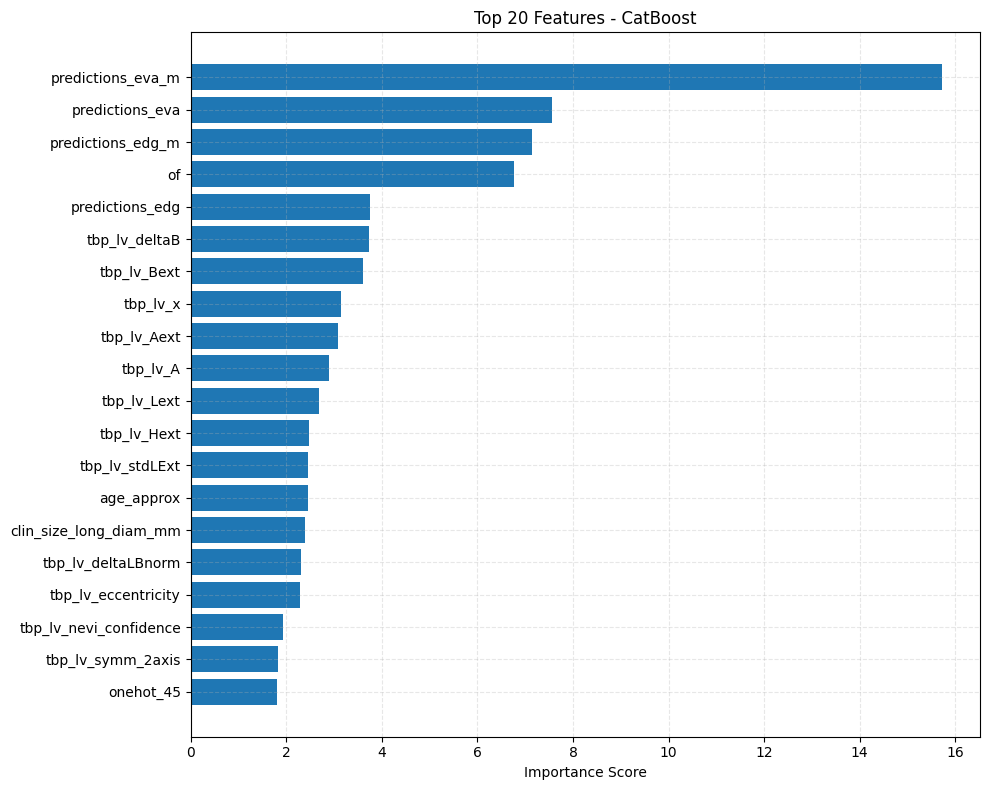

In [143]:
import matplotlib.pyplot as plt

# Choose one of the trained CatBoost models
model = models_cb[0]

# Get feature importances
importances = model.get_feature_importance(type='FeatureImportance')
feature_names = model.feature_names_

# Create a DataFrame for easy sorting & plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 20 features
top_feats = feat_imp_df.head(20)

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.barh(top_feats['feature'][::-1], top_feats['importance'][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Features - CatBoost")
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [144]:
top_feats

,feature,importance
75,predictions_eva_m,15.729915
74,predictions_eva,7.555385
77,predictions_edg_m,7.139196
73,of,6.774304
76,predictions_edg,3.754251
11,tbp_lv_deltaB,3.725458
4,tbp_lv_Bext,3.614502
25,tbp_lv_x,3.156869
3,tbp_lv_Aext,3.089400
2,tbp_lv_A,2.899724


In [145]:
metric_list, models_lgb = run_model_old_lgb(
    lgb_params, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train, savefile='all_feats')

print(np.mean(metric_list))

0.17481292274168


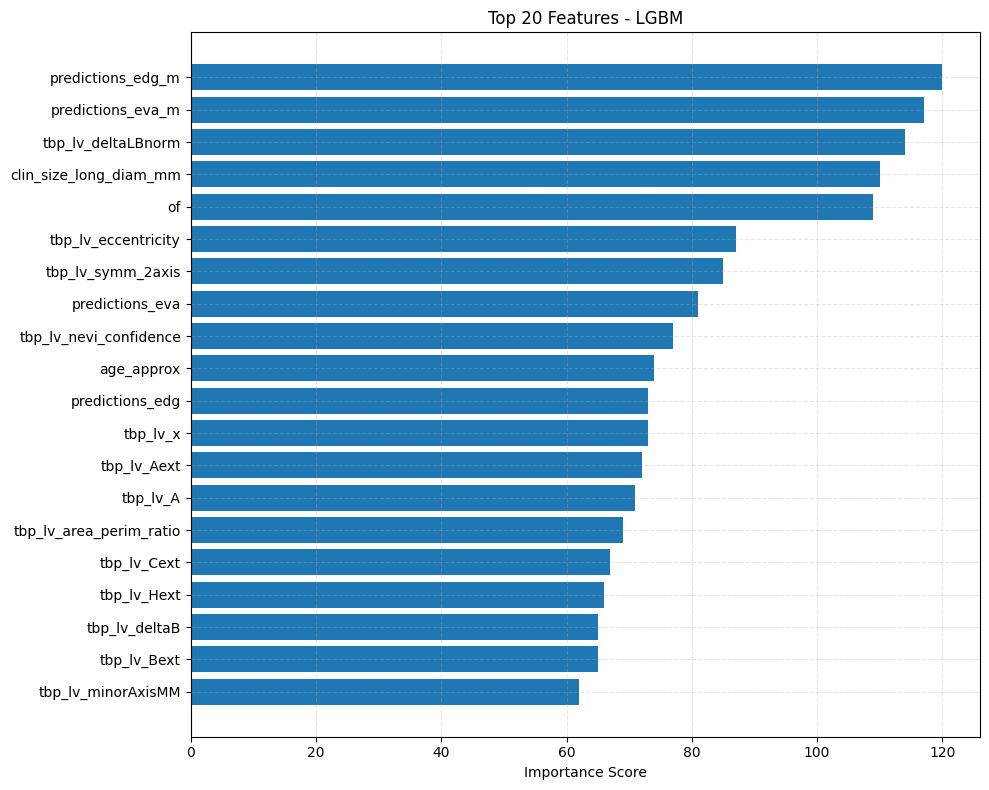

                    feature  importance
77        predictions_edg_m         120
75        predictions_eva_m         117
14       tbp_lv_deltaLBnorm         114
1    clin_size_long_diam_mm         110
73                       of         109
15      tbp_lv_eccentricity          87
23        tbp_lv_symm_2axis          85
74          predictions_eva          81
17   tbp_lv_nevi_confidence          77
0                age_approx          74
76          predictions_edg          73
25                 tbp_lv_x          73
3               tbp_lv_Aext          72
2                  tbp_lv_A          71
9   tbp_lv_area_perim_ratio          69
5               tbp_lv_Cext          67
6               tbp_lv_Hext          66
11            tbp_lv_deltaB          65
4               tbp_lv_Bext          65
16       tbp_lv_minorAxisMM          62


In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Pick the first trained model from models_lgb
model_pipeline = models_lgb[0]

# Extract the LGBM model from pipeline
lgb_model = model_pipeline.named_steps['classifier']

# Get feature importances
importances = lgb_model.feature_importances_
feature_names = lgb_model.feature_name_

# Create DataFrame for visualization
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 20
top_feats = feat_imp_df.head(20)

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.barh(top_feats['feature'][::-1], top_feats['importance'][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Features - LGBM")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: print to check
print(top_feats)

In [148]:
metric_list, models_xgb = run_model_old_xgb(
    xgb_params, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train, savefile='all_feats')

print(np.mean(metric_list))

0.17451598893015374


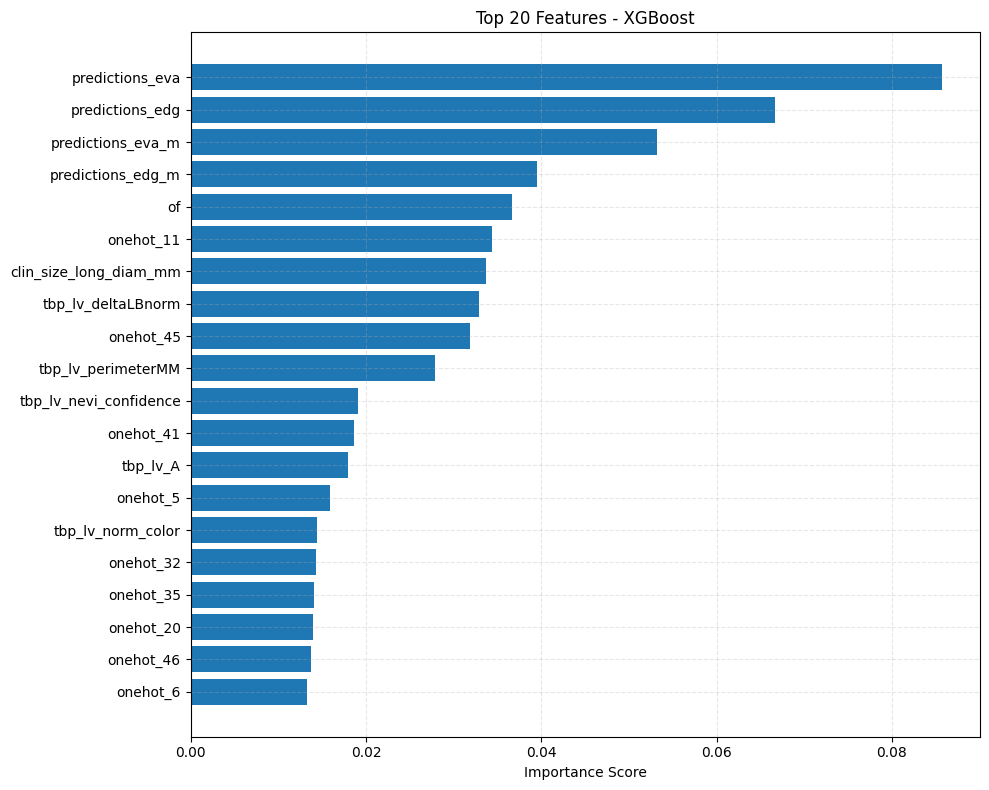

                   feature  importance
74         predictions_eva    0.085754
76         predictions_edg    0.066659
75       predictions_eva_m    0.053245
77       predictions_edg_m    0.039534
73                      of    0.036675
37               onehot_11    0.034406
1   clin_size_long_diam_mm    0.033695
14      tbp_lv_deltaLBnorm    0.032852
71               onehot_45    0.031905
20      tbp_lv_perimeterMM    0.027870
17  tbp_lv_nevi_confidence    0.019114
67               onehot_41    0.018679
2                 tbp_lv_A    0.017945
31                onehot_5    0.015950
19       tbp_lv_norm_color    0.014444
58               onehot_32    0.014332
61               onehot_35    0.014096
46               onehot_20    0.013941
72               onehot_46    0.013763
32                onehot_6    0.013254


In [149]:
import pandas as pd
import matplotlib.pyplot as plt

# Get first trained XGB model from your list (inside pipeline)
model_pipeline = models_xgb[0]  # Assuming this is your model list
xgb_model = model_pipeline.named_steps['classifier']  # Extract XGB model

# Get feature importances
importances = xgb_model.feature_importances_
feature_names = xgb_model.get_booster().feature_names

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Get top 20
top_feats = feat_imp_df.head(20)

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.barh(top_feats['feature'][::-1], top_feats['importance'][::-1])
plt.xlabel("Importance Score")
plt.title("Top 20 Features - XGBoost")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: show values
print(top_feats)


# Prediction on Test

In [43]:
for col in feature_cols: 
    df_test[col].replace([np.inf, -np.inf], np.nan, inplace=True)

In [44]:
def get_model_predictions(models_list, df_test, feature_cols, columns_to_drop):
    df_test_size = int(df_test.shape[0] // 2)
    predictions_tmp = None
    for model in models_list:
        preds_tmp = model.predict_proba(
                df_test[[i for i in feature_cols if i not in columns_to_drop]])[:, 1]

        preds_tmp = pd.DataFrame({"preds": preds_tmp})
        preds_tmp = preds_tmp['preds'].rank(pct=True)

        if predictions_tmp is None:
            predictions_tmp = preds_tmp.values
        else:
            predictions_tmp += preds_tmp.values

    predictions_tmp = predictions_tmp / len(models_list)
    return predictions_tmp

In [45]:
predictions_cb = get_model_predictions(models_cb, df_test, feature_cols, columns_to_drop)
predictions_xgb = get_model_predictions(models_xgb, df_test, feature_cols, columns_to_drop)
predictions_lgb = get_model_predictions(models_lgb, df_test, feature_cols, columns_to_drop)

In [46]:
predictions = (
    predictions_lgb +
    predictions_cb +
    predictions_xgb
) / 3

df_subm['target'] = predictions


df_subm.to_csv('submission.csv')
df_subm.head()

,target
isic_id,
ISIC_0015657,0.666667
ISIC_0015729,0.355556
ISIC_0015740,0.977778


# Cross Val Result on Original Data Using Best Solution

In [150]:
import pandas as pd

xgb_oof = pd.read_parquet('../result/xgboost_all_fold_predictions_all_feat.parquet')
lgb_oof = pd.read_parquet('../result/lightgbm_all_fold_predictions_all_feat.parquet')
cb_oof  = pd.read_parquet('../result/catboost_all_fold_predictions_all_feat.parquet')

df = xgb_oof[['isic_id', 'target', 'pred']].rename(columns={'pred': 'xgb_pred'}) \
     .merge(lgb_oof[['isic_id', 'pred']].rename(columns={'pred': 'lgb_pred'}), on='isic_id') \
     .merge(cb_oof[['isic_id', 'pred']].rename(columns={'pred': 'cb_pred'}), on='isic_id')

df['ensemble_pred'] = (df['xgb_pred'] + df['lgb_pred'] + df['cb_pred']) / 3

# Calculate ensemble CV pAUC
score = custom_metric_raw(df['ensemble_pred'].values, df['target'].values)

print('Ensemble CV pAUC Score:', score)

Ensemble CV pAUC Score: 0.17550003798383068


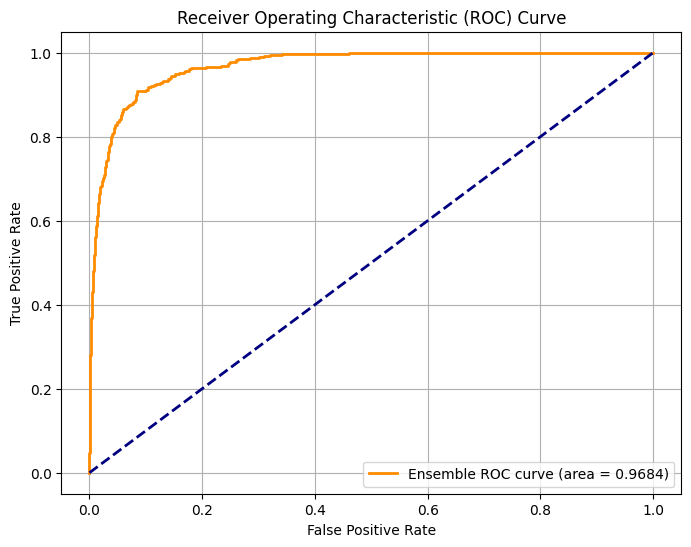

In [154]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load predictions
xgb_oof = pd.read_parquet('../result/xgboost_all_fold_predictions_all_feat.parquet')
lgb_oof = pd.read_parquet('../result/lightgbm_all_fold_predictions_all_feat.parquet')
cb_oof = pd.read_parquet('../result/catboost_all_fold_predictions_all_feat.parquet')

# Merge predictions
df = xgb_oof[['isic_id', 'target', 'pred']].rename(columns={'pred': 'xgb_pred'}) \
    .merge(lgb_oof[['isic_id', 'pred']].rename(columns={'pred': 'lgb_pred'}), on='isic_id') \
    .merge(cb_oof[['isic_id', 'pred']].rename(columns={'pred': 'cb_pred'}), on='isic_id')

df['ensemble_pred'] = (df['xgb_pred'] + df['lgb_pred'] + df['cb_pred']) / 3

# Calculate ROC
fpr, tpr, _ = roc_curve(df['target'], df['ensemble_pred'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


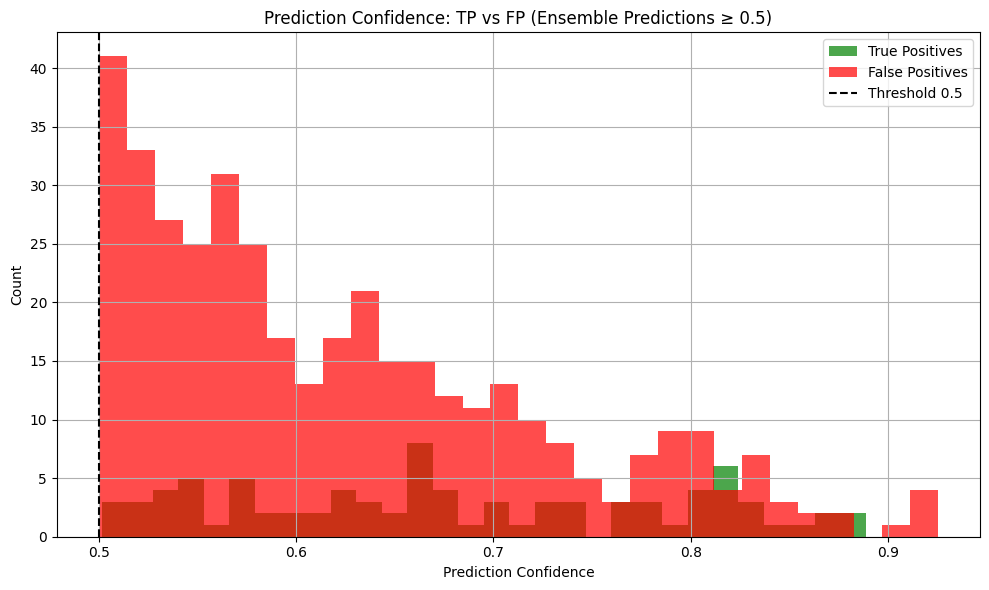

In [152]:
import matplotlib.pyplot as plt
import pandas as pd

# Load preds
xgb_oof = pd.read_parquet('../result/xgboost_all_fold_predictions_all_feat.parquet')
lgb_oof = pd.read_parquet('../result/lightgbm_all_fold_predictions_all_feat.parquet')
cb_oof  = pd.read_parquet('../result/catboost_all_fold_predictions_all_feat.parquet')

df = xgb_oof[['isic_id', 'target', 'pred']].rename(columns={'pred': 'xgb_pred'}) \
     .merge(lgb_oof[['isic_id', 'pred']].rename(columns={'pred': 'lgb_pred'}), on='isic_id') \
     .merge(cb_oof[['isic_id', 'pred']].rename(columns={'pred': 'cb_pred'}), on='isic_id')

df['ensemble_pred'] = (df['xgb_pred'] + df['lgb_pred'] + df['cb_pred']) / 3

# Create TP and FP mask based on threshold=0.5
TP = df[(df['ensemble_pred'] >= 0.5) & (df['target'] == 1)]
FP = df[(df['ensemble_pred'] >= 0.5) & (df['target'] == 0)]

plt.figure(figsize=(10, 6))
plt.hist(TP['ensemble_pred'], bins=30, alpha=0.7, label='True Positives', color='g')
plt.hist(FP['ensemble_pred'], bins=30, alpha=0.7, label='False Positives', color='r')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Prediction Confidence: TP vs FP (Ensemble Predictions ≥ 0.5)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


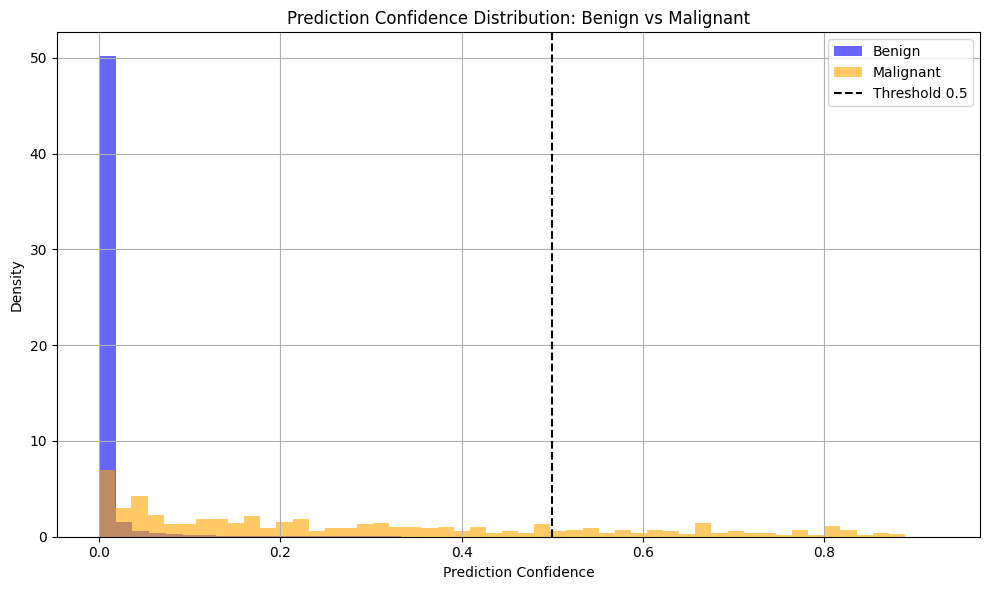

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# Load predictions
xgb_oof = pd.read_parquet('../result/xgboost_all_fold_predictions_all_feat.parquet')
lgb_oof = pd.read_parquet('../result/lightgbm_all_fold_predictions_all_feat.parquet')
cb_oof  = pd.read_parquet('../result/catboost_all_fold_predictions_all_feat.parquet')

# Merge and create ensemble
df = xgb_oof[['isic_id', 'target', 'pred']].rename(columns={'pred': 'xgb_pred'}) \
     .merge(lgb_oof[['isic_id', 'pred']].rename(columns={'pred': 'lgb_pred'}), on='isic_id') \
     .merge(cb_oof[['isic_id', 'pred']].rename(columns={'pred': 'cb_pred'}), on='isic_id')

df['ensemble_pred'] = (df['xgb_pred'] + df['lgb_pred'] + df['cb_pred']) / 3

# Split by target
benign = df[df['target'] == 0]
malignant = df[df['target'] == 1]

# Plot
plt.figure(figsize=(10, 6))
plt.hist(benign['ensemble_pred'], bins=50, alpha=0.6, label='Benign', color='b', density=True)
plt.hist(malignant['ensemble_pred'], bins=50, alpha=0.6, label='Malignant', color='orange', density=True)

plt.axvline(0.5, color='black', linestyle='--', label='Threshold 0.5')
plt.xlabel('Prediction Confidence')
plt.ylabel('Density')
plt.title('Prediction Confidence Distribution: Benign vs Malignant')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Confusion Matrix:
[[400276    390]
 [   308     85]]


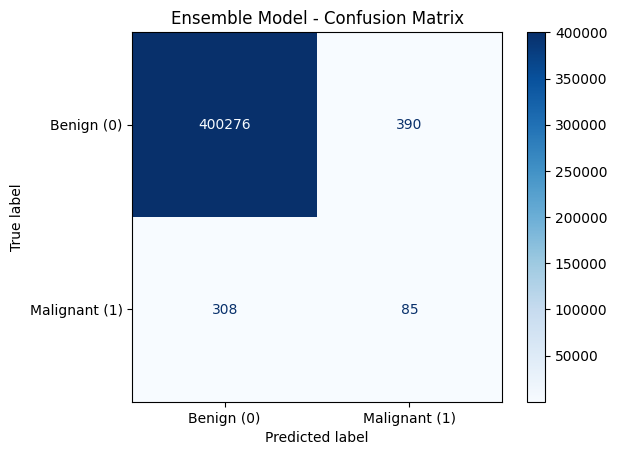

In [151]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Threshold ensemble predictions
threshold = 0.5
df['ensemble_pred_class'] = (df['ensemble_pred'] >= threshold).astype(int)

# Generate Confusion Matrix
cm = confusion_matrix(df['target'], df['ensemble_pred_class'])

print("Confusion Matrix:")
print(cm)

# Optional: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Ensemble Model - Confusion Matrix')
plt.show()


# Cross Val Result Using Only Original Data

In [ ]:
df_train_original = df_train[[group_col]+num_cols+cat_cols+[target_col]]
df_train_original = df_train_original[[col for col in df_train_original.columns if 'onehot' not in col]]
print(df_train_original.shape)

(401059, 36)
(3, 35)


In [95]:
df_train_original.columns

Index(['patient_id', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'target'],
      dtype='object')

In [104]:
model_config_cb = ModelConfigCB(**{
     'learning_rate': 0.02606161517843435,
     'l2_leaf_reg': 18.04422276698195,
     'random_strength': 4.7069580783889995,
     'depth': 6,
     'bagging_temperature': 0.8735940473548339,
     'border_count': 256,
     'grow_policy': 'Lossguide',
     'min_data_in_leaf': 38})

metric_list, models_cb = run_model_cb(
    model_config_cb.dict(), test=True, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train_original, savefile='original_feats')

print(np.mean(metric_list))

0it [00:00, ?it/s]Default metric period is 5 because AUC is/are not implemented for GPU
1it [00:06,  6.37s/it]Default metric period is 5 because AUC is/are not implemented for GPU
2it [00:10,  4.84s/it]Default metric period is 5 because AUC is/are not implemented for GPU
3it [00:12,  3.73s/it]Default metric period is 5 because AUC is/are not implemented for GPU
4it [00:16,  3.72s/it]Default metric period is 5 because AUC is/are not implemented for GPU
5it [00:19,  4.00s/it]

0.15270228255525692


In [107]:
metric_list, models_lgb = run_model_old_lgb(
    lgb_params, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train_original, savefile='original_feats')

print(np.mean(metric_list))

0.1527470888426722


In [108]:
metric_list, models_xgb = run_model_old_xgb(
    xgb_params, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train_original, savefile='original_feats')

print(np.mean(metric_list))

0.14825666132056178


In [112]:
import pandas as pd

xgb_oof = pd.read_parquet('../result/xgboost_all_fold_predictions_original_feats.parquet')
lgb_oof = pd.read_parquet('../result/lightgbm_all_fold_predictions_original_feats.parquet')
cb_oof  = pd.read_parquet('../result/catboost_all_fold_predictions_original_feats.parquet')

df = xgb_oof[['isic_id', 'target', 'pred']].rename(columns={'pred': 'xgb_pred'}) \
     .merge(lgb_oof[['isic_id', 'pred']].rename(columns={'pred': 'lgb_pred'}), on='isic_id') \
     .merge(cb_oof[['isic_id', 'pred']].rename(columns={'pred': 'cb_pred'}), on='isic_id')

df['ensemble_pred'] = (df['xgb_pred'] + df['lgb_pred'] + df['cb_pred']) / 3

# Calculate ensemble CV pAUC
score = custom_metric_raw(df['ensemble_pred'].values, df['target'].values)

print('Ensemble CV pAUC Score:', score)

Ensemble CV pAUC Score: 0.14985873076035774


# Cross Val Result Using Feat Engineering without Image model Preds

In [119]:
df_train.columns[-15:]

Index(['onehot_45', 'onehot_46', 'of', 'old_set_0', 'old_set_1', 'old_set_2',
       'old_set_0_m', 'old_set_1_m', 'old_set_2_m', 'patient_id_y',
       'predictions_eva', 'predictions_eva_m', 'patient_id', 'predictions_edg',
       'predictions_edg_m'],
      dtype='object')

In [120]:
cols_to_exclude = ['old_set_0', 'old_set_1', 'old_set_2', 'old_set_0_m', 'old_set_1_m', 'old_set_2_m', 'predictions_eva',
                    'predictions_eva_m', 'predictions_edg','predictions_edg_m']
df_train_feat_engr = df_train.drop(columns=[col for col in cols_to_exclude if col in df_train.columns])
print(df_train_feat_engr.shape)

(401059, 227)


In [124]:
model_config_cb = ModelConfigCB(**{
     'learning_rate': 0.02606161517843435,
     'l2_leaf_reg': 18.04422276698195,
     'random_strength': 4.7069580783889995,
     'depth': 6,
     'bagging_temperature': 0.8735940473548339,
     'border_count': 256,
     'grow_policy': 'Lossguide',
     'min_data_in_leaf': 38})

metric_list, models_cb = run_model_cb(
    model_config_cb.dict(), test=True, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train_feat_engr, savefile='custom_feats_without_old_model_preds')

print(np.mean(metric_list))

0it [00:00, ?it/s]Default metric period is 5 because AUC is/are not implemented for GPU
1it [00:06,  6.54s/it]Default metric period is 5 because AUC is/are not implemented for GPU
2it [00:10,  5.00s/it]Default metric period is 5 because AUC is/are not implemented for GPU
3it [00:15,  5.04s/it]Default metric period is 5 because AUC is/are not implemented for GPU
4it [00:19,  4.69s/it]Default metric period is 5 because AUC is/are not implemented for GPU
5it [00:23,  4.61s/it]

0.16504762093802464


In [125]:
metric_list, models_lgb = run_model_old_lgb(
    lgb_params, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train_feat_engr, savefile='custom_feats_without_old_model_preds')

print(np.mean(metric_list))

0.16328905133311108


In [126]:
metric_list, models_xgb = run_model_old_xgb(
    xgb_params, reduce=False, columns_to_drop=columns_to_drop, df_train=df_train_feat_engr, savefile='custom_feats_without_old_model_preds')

print(np.mean(metric_list))

0.16366703335993876


In [130]:
import pandas as pd

xgb_oof = pd.read_parquet('../result/xgboost_all_fold_predictions_custom_feats_without_old_model_preds.parquet')
lgb_oof = pd.read_parquet('../result/lightgbm_all_fold_predictions_custom_feats_without_old_model_preds.parquet')
cb_oof  = pd.read_parquet('../result/catboost_all_fold_predictions_custom_feats_without_old_model_preds.parquet')

df = xgb_oof[['isic_id', 'target', 'pred']].rename(columns={'pred': 'xgb_pred'}) \
     .merge(lgb_oof[['isic_id', 'pred']].rename(columns={'pred': 'lgb_pred'}), on='isic_id') \
     .merge(cb_oof[['isic_id', 'pred']].rename(columns={'pred': 'cb_pred'}), on='isic_id')

df['ensemble_pred'] = (df['xgb_pred'] + df['lgb_pred'] + df['cb_pred']) / 3

# Calculate ensemble CV pAUC
score = custom_metric_raw(df['ensemble_pred'].values, df['target'].values)

print('Ensemble CV pAUC Score:', score)

Ensemble CV pAUC Score: 0.16444659717905563


In [138]:
df_train.columns[200:238]

Index(['onehot_23', 'onehot_24', 'onehot_25', 'onehot_26', 'onehot_27',
       'onehot_28', 'onehot_29', 'onehot_30', 'onehot_31', 'onehot_32',
       'onehot_33', 'onehot_34', 'onehot_35', 'onehot_36', 'onehot_37',
       'onehot_38', 'onehot_39', 'onehot_40', 'onehot_41', 'onehot_42',
       'onehot_43', 'onehot_44', 'onehot_45', 'onehot_46', 'of', 'old_set_0',
       'old_set_1', 'old_set_2', 'old_set_0_m', 'old_set_1_m', 'old_set_2_m',
       'patient_id_y', 'predictions_eva', 'predictions_eva_m', 'patient_id',
       'predictions_edg', 'predictions_edg_m'],
      dtype='object')

In [139]:
df_train.target.value_counts()

target
0    400666
1       393
Name: count, dtype: int64